# 03 — Class Imbalance Strategies & Feature Selection
**Ensemble Early Parkinson Detection Using Voice Biomarkers**

This notebook investigates two critical methodological dimensions:

**Part A — Class Imbalance Handling:**
1. No balancing (baseline from Notebook 02)
2. Class weighting (`class_weight='balanced'`)
3. SMOTE (applied within training folds only)

**Part B — Feature Selection:**
1. All 22 features (baseline)
2. PCA (5–15 components)
3. RFE with SVM and Random Forest

**Part C — Combined Analysis:**
Best imbalance strategy × best feature set for each classifier.

All experiments use subject-wise GroupKFold (5 folds).

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from src.data_utils import load_parkinsons, get_X_y_groups, FEATURE_COLS, FEATURE_GROUPS
from src.eval_utils import (
    compute_metrics, results_to_dataframe, plot_confusion_matrix,
    plot_multiple_confusion_matrices
)
from src.pipeline_utils import (
    build_pipeline, run_grouped_cv, get_classifiers, run_all_baselines
)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

RANDOM_STATE = 42
N_SPLITS = 5

df = load_parkinsons()
X, y, groups = get_X_y_groups(df)
print(f'X: {X.shape}, y: {y.shape}, Subjects: {groups.nunique()}')

X: (195, 22), y: (195,), Subjects: 32


---
# Part A: Class Imbalance Strategies

We compare three approaches across all classifiers:
- **No balancing**: Baseline (already computed in Notebook 02)
- **Class weighting**: Adjusts loss function to penalize minority-class errors more heavily
- **SMOTE**: Generates synthetic minority samples in training folds only

## 2. Run All Imbalance Strategies

In [2]:
imbalance_results = {}

# Strategy 1: No balancing
print('=== Strategy 1: No Balancing ===')
imbalance_results['no_balancing'] = run_all_baselines(
    X, y, groups, use_smote=False, class_weight=None, n_splits=N_SPLITS
)

# Strategy 2: Class weighting
print('\n=== Strategy 2: Class Weighting ===')
imbalance_results['class_weight'] = run_all_baselines(
    X, y, groups, use_smote=False, class_weight='balanced', n_splits=N_SPLITS
)

# Strategy 3: SMOTE
print('\n=== Strategy 3: SMOTE ===')
imbalance_results['smote'] = run_all_baselines(
    X, y, groups, use_smote=True, class_weight=None, n_splits=N_SPLITS
)

print('\nDone!')

=== Strategy 1: No Balancing ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

=== Strategy 2: Class Weighting ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

=== Strategy 3: SMOTE ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

Done!


In [3]:
# Build a comprehensive comparison table
rows = []
for strategy_name, strategy_results in imbalance_results.items():
    for model_name, cv_result in strategy_results.items():
        row = {'strategy': strategy_name, 'model': model_name}
        row.update(cv_result['mean_metrics'])
        rows.append(row)

imb_df = pd.DataFrame(rows)
imb_df = imb_df.round(4)

# Display as pivot tables for each key metric
for metric in ['balanced_accuracy', 'sensitivity', 'specificity', 'f1', 'mcc', 'auc_roc']:
    pivot = imb_df.pivot(index='model', columns='strategy', values=metric)
    pivot = pivot[['no_balancing', 'class_weight', 'smote']]  # order columns
    print(f'\n--- {metric.upper()} ---')
    print(pivot.to_string())


--- BALANCED_ACCURACY ---
strategy       no_balancing  class_weight   smote
model                                            
KNN                  0.6086        0.6086  0.6745
Logistic_L1          0.6879        0.6817  0.6733
Logistic_L2          0.6886        0.6567  0.6484
Random_Forest        0.6753        0.6481  0.6284
SVM_Linear           0.6474        0.6304  0.6335
SVM_RBF              0.6418        0.6049  0.6095

--- SENSITIVITY ---
strategy       no_balancing  class_weight   smote
model                                            
KNN                  0.8840        0.8840  0.7657
Logistic_L1          0.8924        0.8135  0.8132
Logistic_L2          0.8939        0.8135  0.8135
Random_Forest        0.9340        0.9129  0.8735
SVM_Linear           0.8948        0.7775  0.8003
SVM_RBF              0.9335        0.7432  0.7857

--- SPECIFICITY ---
strategy       no_balancing  class_weight   smote
model                                            
KNN                  0.3333    

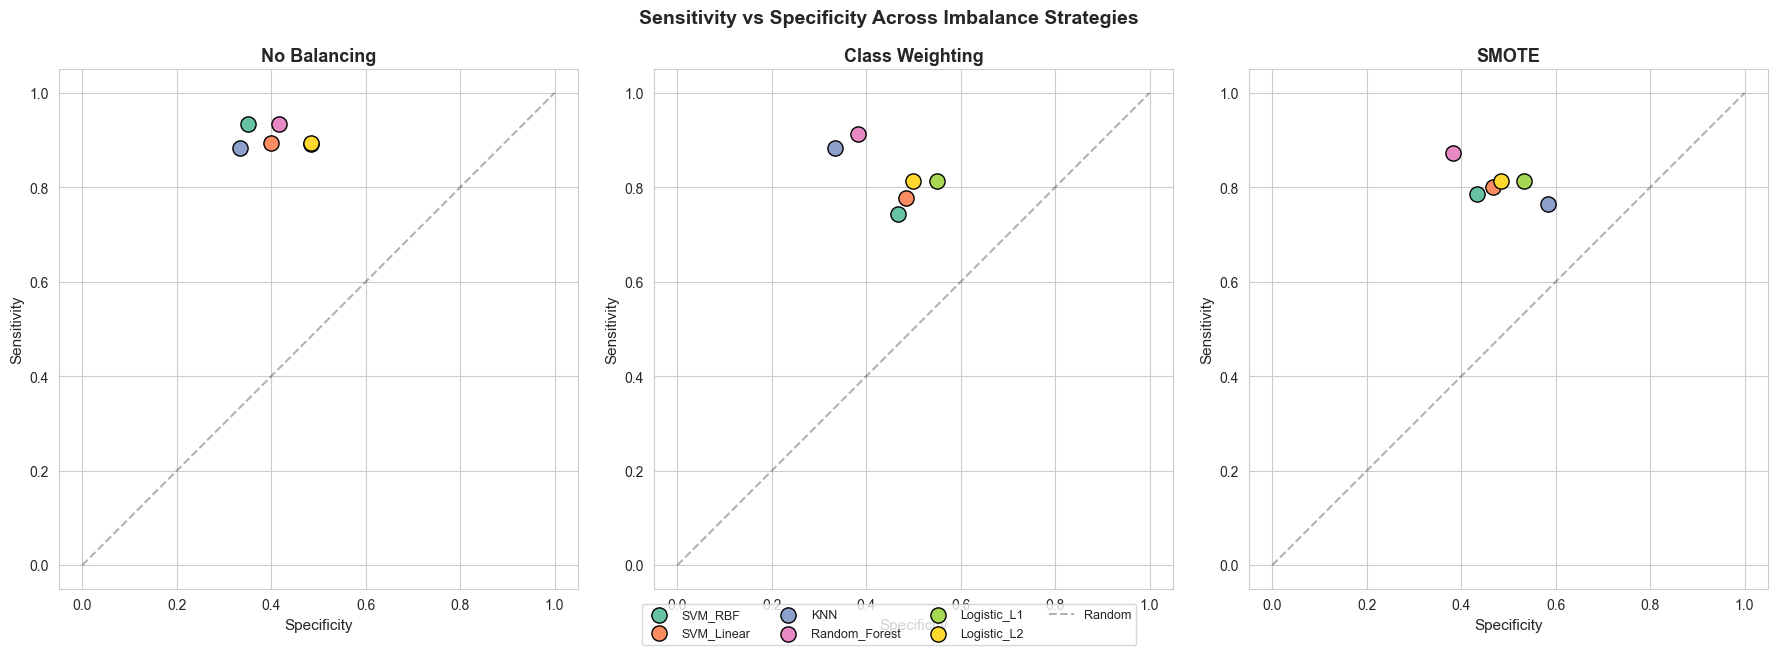

In [4]:
# Visualize: Sensitivity vs Specificity tradeoff by strategy
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

strategies = ['no_balancing', 'class_weight', 'smote']
strategy_labels = ['No Balancing', 'Class Weighting', 'SMOTE']
models = list(imbalance_results['no_balancing'].keys())
colors = sns.color_palette('Set2', len(models))

for ax, strat, strat_label in zip(axes, strategies, strategy_labels):
    for model, color in zip(models, colors):
        sens = imbalance_results[strat][model]['mean_metrics']['sensitivity']
        spec = imbalance_results[strat][model]['mean_metrics']['specificity']
        ax.scatter(spec, sens, c=[color], s=120, label=model, edgecolors='black', zorder=3)
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
    ax.set_xlabel('Specificity', fontsize=11)
    ax.set_ylabel('Sensitivity', fontsize=11)
    ax.set_title(strat_label, fontsize=13, fontweight='bold')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')

# Single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=9,
           bbox_to_anchor=(0.5, -0.05))

plt.suptitle('Sensitivity vs Specificity Across Imbalance Strategies',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/imbalance_sens_spec_tradeoff.png', bbox_inches='tight')
plt.show()

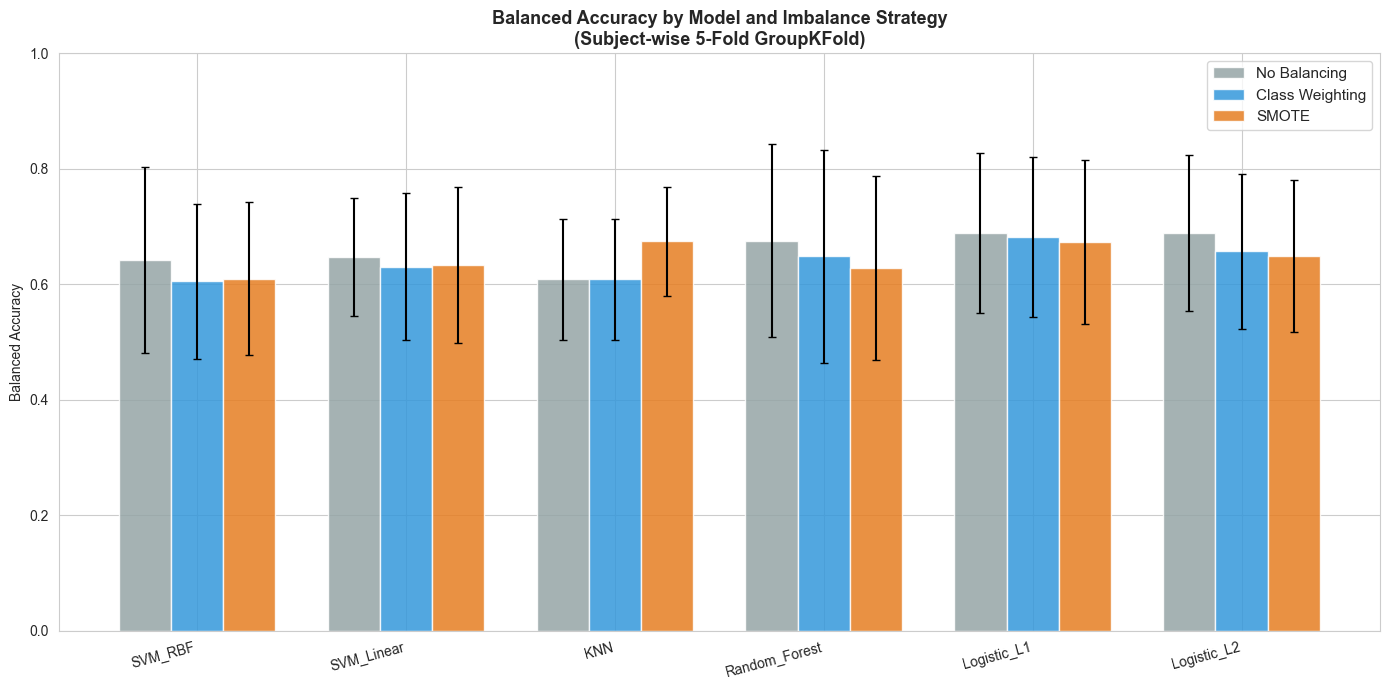

In [5]:
# Bar chart: balanced accuracy across strategies for each model
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(models))
width = 0.25
strat_colors = ['#95a5a6', '#3498db', '#e67e22']

for i, (strat, strat_label, color) in enumerate(zip(strategies, strategy_labels, strat_colors)):
    vals = [imbalance_results[strat][m]['mean_metrics']['balanced_accuracy'] for m in models]
    stds = [imbalance_results[strat][m]['std_metrics']['balanced_accuracy'] for m in models]
    bars = ax.bar(x + i * width, vals, width, label=strat_label, color=color,
                  yerr=stds, capsize=3, alpha=0.85)

ax.set_ylabel('Balanced Accuracy')
ax.set_title('Balanced Accuracy by Model and Imbalance Strategy\n(Subject-wise 5-Fold GroupKFold)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('../figures/imbalance_balanced_accuracy.png', bbox_inches='tight')
plt.show()

In [6]:
# Identify best imbalance strategy per model (by balanced accuracy)
print('Best imbalance strategy per model (by balanced accuracy):\n')
best_imb_per_model = {}
for model in models:
    best_strat = None
    best_ba = -1
    for strat in strategies:
        ba = imbalance_results[strat][model]['mean_metrics']['balanced_accuracy']
        if ba > best_ba:
            best_ba = ba
            best_strat = strat
    best_imb_per_model[model] = best_strat
    print(f'  {model:>15s}: {best_strat} (bal_acc = {best_ba:.4f})')

Best imbalance strategy per model (by balanced accuracy):

          SVM_RBF: no_balancing (bal_acc = 0.6418)
       SVM_Linear: no_balancing (bal_acc = 0.6474)
              KNN: smote (bal_acc = 0.6745)
    Random_Forest: no_balancing (bal_acc = 0.6753)
      Logistic_L1: no_balancing (bal_acc = 0.6879)
      Logistic_L2: no_balancing (bal_acc = 0.6886)


---
# Part B: Feature Selection

We compare three feature strategies:
1. **All 22 features** (baseline)
2. **PCA** (testing 5, 8, 10, 12, 15 components)
3. **RFE** (Recursive Feature Elimination with SVM and Random Forest)

## 3. PCA — Component Selection

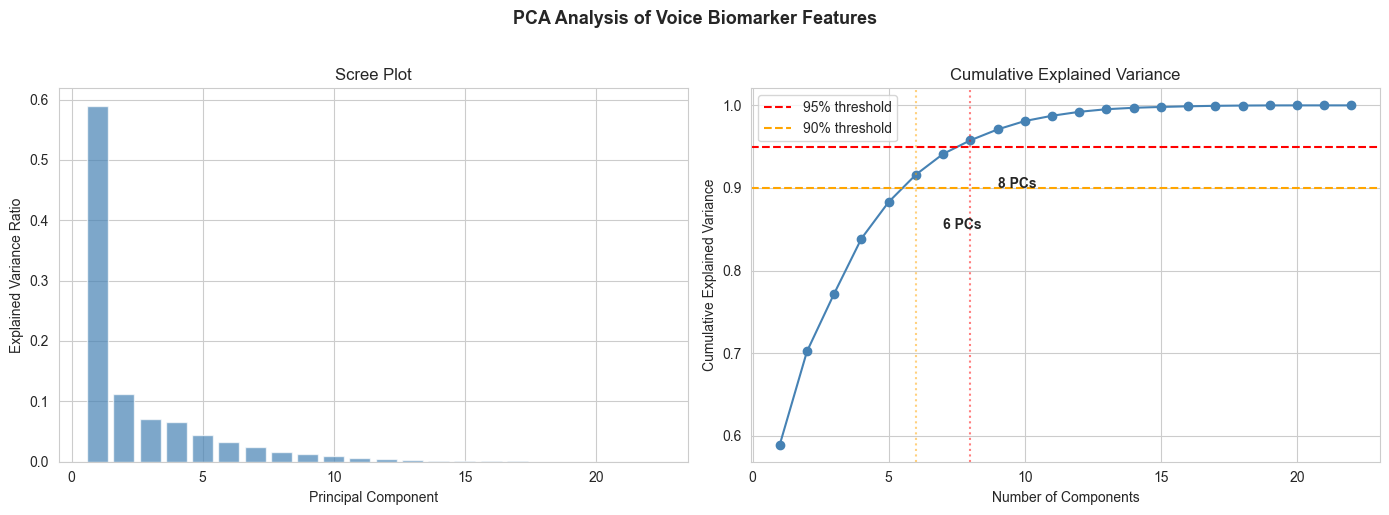

Cumulative explained variance:
  5 components: 88.3%
  8 components: 95.8%
  10 components: 98.1%
  12 components: 99.2%
  15 components: 99.8%


In [7]:
# First, visualize explained variance to guide component selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X)
pca_full = PCA().fit(X_scaled)

cumvar = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')

# Cumulative variance
axes[1].plot(range(1, len(cumvar) + 1), cumvar, 'o-', color='steelblue')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% threshold')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')

# Mark key component counts
for threshold, color in [(0.90, 'orange'), (0.95, 'red')]:
    n_comp = np.argmax(cumvar >= threshold) + 1
    axes[1].axvline(x=n_comp, color=color, linestyle=':', alpha=0.5)
    axes[1].annotate(f'{n_comp} PCs', xy=(n_comp, threshold),
                     xytext=(n_comp + 1, threshold - 0.05),
                     fontsize=10, fontweight='bold')

axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()

plt.suptitle('PCA Analysis of Voice Biomarker Features', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/pca_variance.png', bbox_inches='tight')
plt.show()

print('Cumulative explained variance:')
for i in [5, 8, 10, 12, 15]:
    print(f'  {i} components: {cumvar[i-1]*100:.1f}%')

In [8]:
# Test PCA with varying component counts using SVM-RBF as reference
pca_components_to_test = [5, 8, 10, 12, 15]
pca_results = {}

# Use class_weight='balanced' for fair comparison
ref_clf = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=RANDOM_STATE)

# Baseline: all features, no PCA
print('Testing PCA components with SVM-RBF (class_weight=balanced)...')
pipe_no_pca = build_pipeline(ref_clf, use_pca=False)
pca_results['All 22 features'] = run_grouped_cv(pipe_no_pca, X, y, groups, n_splits=N_SPLITS)

for n_comp in pca_components_to_test:
    print(f'  PCA n={n_comp}...')
    clf = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=RANDOM_STATE)
    pipe = build_pipeline(clf, use_pca=True, n_components=n_comp)
    pca_results[f'PCA ({n_comp})'] = run_grouped_cv(pipe, X, y, groups, n_splits=N_SPLITS)

# Compare
pca_summary = {name: res['mean_metrics'] for name, res in pca_results.items()}
pca_df = results_to_dataframe(pca_summary)
print('\n--- PCA Component Comparison (SVM-RBF, balanced) ---\n')
pca_df

Testing PCA components with SVM-RBF (class_weight=balanced)...
  PCA n=5...
  PCA n=8...
  PCA n=10...
  PCA n=12...
  PCA n=15...

--- PCA Component Comparison (SVM-RBF, balanced) ---



,accuracy,balanced_accuracy,sensitivity,specificity,precision,f1,mcc,auc_roc
Model,,,,,,,,
All 22 features,0.6746,0.6049,0.7432,0.4667,0.8146,0.7663,0.1828,0.7368
PCA (5),0.6721,0.6213,0.7258,0.5167,0.8364,0.7580,0.2305,0.8249
PCA (8),0.6591,0.5952,0.7237,0.4667,0.8106,0.7521,0.1676,0.7759
PCA (10),0.6807,0.6081,0.7495,0.4667,0.8128,0.7689,0.1867,0.7662
PCA (12),0.6855,0.6114,0.7561,0.4667,0.8157,0.7745,0.1927,0.7567
PCA (15),0.6801,0.6082,0.7497,0.4667,0.8157,0.7698,0.1873,0.7400


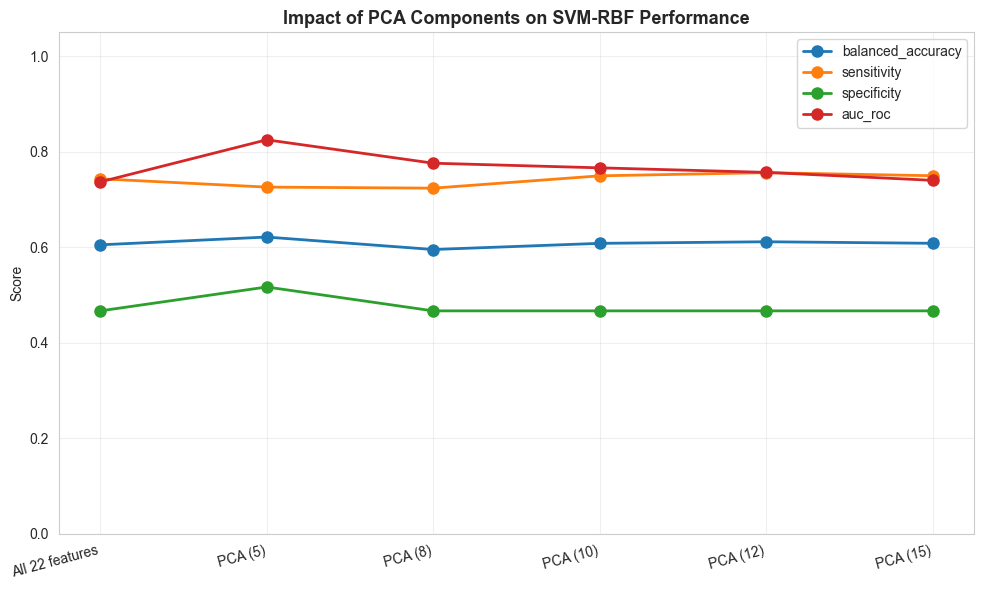

In [9]:
# Visualize PCA component impact
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_track = ['balanced_accuracy', 'sensitivity', 'specificity', 'auc_roc']
x_labels = list(pca_summary.keys())
x_pos = range(len(x_labels))

for metric in metrics_to_track:
    vals = [pca_summary[name][metric] for name in x_labels]
    ax.plot(x_pos, vals, 'o-', label=metric, linewidth=2, markersize=8)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=15, ha='right')
ax.set_ylabel('Score')
ax.set_title('Impact of PCA Components on SVM-RBF Performance', fontsize=13, fontweight='bold')
ax.legend()
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/pca_component_impact.png', bbox_inches='tight')
plt.show()

## 4. RFE — Recursive Feature Elimination

We run RFE inside each CV fold to prevent leakage. We use two estimators for RFE: SVM (linear) and Random Forest, then evaluate selected features with all classifiers.

In [10]:
from sklearn.feature_selection import RFE
from collections import Counter

def run_rfe_cv(X, y, groups, estimator, n_features_to_select, n_splits=5):
    """
    Run RFE inside each GroupKFold fold and track which features
    are selected across folds (for stability analysis).
    """
    gkf = GroupKFold(n_splits=n_splits)
    scaler = StandardScaler()
    feature_votes = Counter()  # how many folds selected each feature
    all_rankings = []
    
    for train_idx, test_idx in gkf.split(X, y, groups):
        X_train = scaler.fit_transform(X.iloc[train_idx])
        y_train = y.iloc[train_idx]
        
        rfe = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            rfe.fit(X_train, y_train)
        
        selected = [FEATURE_COLS[i] for i in range(len(FEATURE_COLS)) if rfe.support_[i]]
        for feat in selected:
            feature_votes[feat] += 1
        all_rankings.append(rfe.ranking_)
    
    # Average ranking across folds
    avg_ranking = np.mean(all_rankings, axis=0)
    ranking_df = pd.DataFrame({
        'feature': FEATURE_COLS,
        'avg_ranking': avg_ranking,
        'times_selected': [feature_votes[f] for f in FEATURE_COLS]
    }).sort_values('avg_ranking')
    
    # Consensus features: selected in majority of folds
    consensus_features = [f for f, count in feature_votes.items() if count >= n_splits // 2 + 1]
    
    return ranking_df, consensus_features


# RFE with SVM (linear kernel)
print('Running RFE with SVM (linear)...')
svm_estimator = SVC(kernel='linear', class_weight='balanced', random_state=RANDOM_STATE)
svm_rfe_ranking, svm_rfe_features = run_rfe_cv(
    X, y, groups, svm_estimator, n_features_to_select=10, n_splits=N_SPLITS
)
print(f'SVM-RFE consensus features ({len(svm_rfe_features)}): {svm_rfe_features}')

# RFE with Random Forest
print('\nRunning RFE with Random Forest...')
rf_estimator = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
rf_rfe_ranking, rf_rfe_features = run_rfe_cv(
    X, y, groups, rf_estimator, n_features_to_select=10, n_splits=N_SPLITS
)
print(f'RF-RFE consensus features ({len(rf_rfe_features)}): {rf_rfe_features}')

Running RFE with SVM (linear)...
SVM-RFE consensus features (10): ['MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:APQ', 'spread1', 'D2', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'NHR', 'PPE']

Running RFE with Random Forest...
RF-RFE consensus features (8): ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'Shimmer:APQ5', 'MDVP:APQ', 'spread1', 'spread2', 'D2', 'PPE']


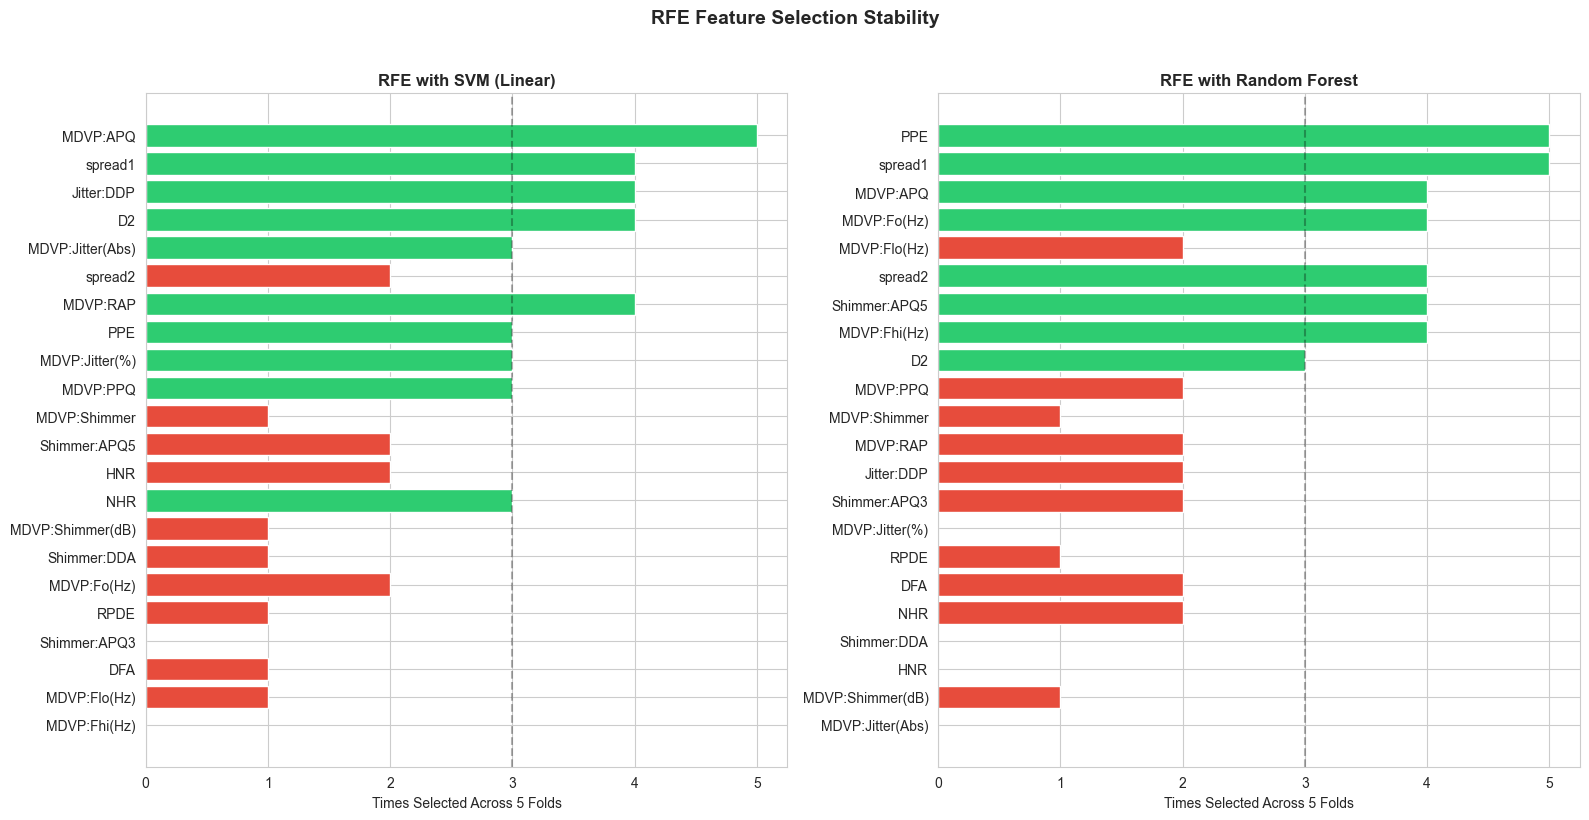

In [11]:
# Visualize feature rankings from both RFE methods
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, ranking_df, title in [
    (axes[0], svm_rfe_ranking, 'RFE with SVM (Linear)'),
    (axes[1], rf_rfe_ranking, 'RFE with Random Forest')
]:
    colors = ['#2ecc71' if ts >= 3 else '#e74c3c' for ts in ranking_df['times_selected']]
    ax.barh(ranking_df['feature'], ranking_df['times_selected'], color=colors, edgecolor='white')
    ax.set_xlabel('Times Selected Across 5 Folds')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axvline(x=3, color='black', linestyle='--', alpha=0.3, label='Majority threshold')
    ax.invert_yaxis()

plt.suptitle('RFE Feature Selection Stability', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/rfe_feature_stability.png', bbox_inches='tight')
plt.show()

In [12]:
# Feature overlap between SVM-RFE and RF-RFE
overlap = set(svm_rfe_features) & set(rf_rfe_features)
svm_only = set(svm_rfe_features) - set(rf_rfe_features)
rf_only = set(rf_rfe_features) - set(svm_rfe_features)

print(f'Features selected by BOTH methods ({len(overlap)}): {sorted(overlap)}')
print(f'SVM-RFE only ({len(svm_only)}): {sorted(svm_only)}')
print(f'RF-RFE only ({len(rf_only)}): {sorted(rf_only)}')

# Union set for a robust feature set
union_features = sorted(set(svm_rfe_features) | set(rf_rfe_features))
print(f'\nUnion feature set ({len(union_features)}): {union_features}')

Features selected by BOTH methods (4): ['D2', 'MDVP:APQ', 'PPE', 'spread1']
SVM-RFE only (6): ['Jitter:DDP', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:PPQ', 'MDVP:RAP', 'NHR']
RF-RFE only (4): ['MDVP:Fhi(Hz)', 'MDVP:Fo(Hz)', 'Shimmer:APQ5', 'spread2']

Union feature set (14): ['D2', 'Jitter:DDP', 'MDVP:APQ', 'MDVP:Fhi(Hz)', 'MDVP:Fo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:PPQ', 'MDVP:RAP', 'NHR', 'PPE', 'Shimmer:APQ5', 'spread1', 'spread2']


## 5. Random Forest Feature Importance

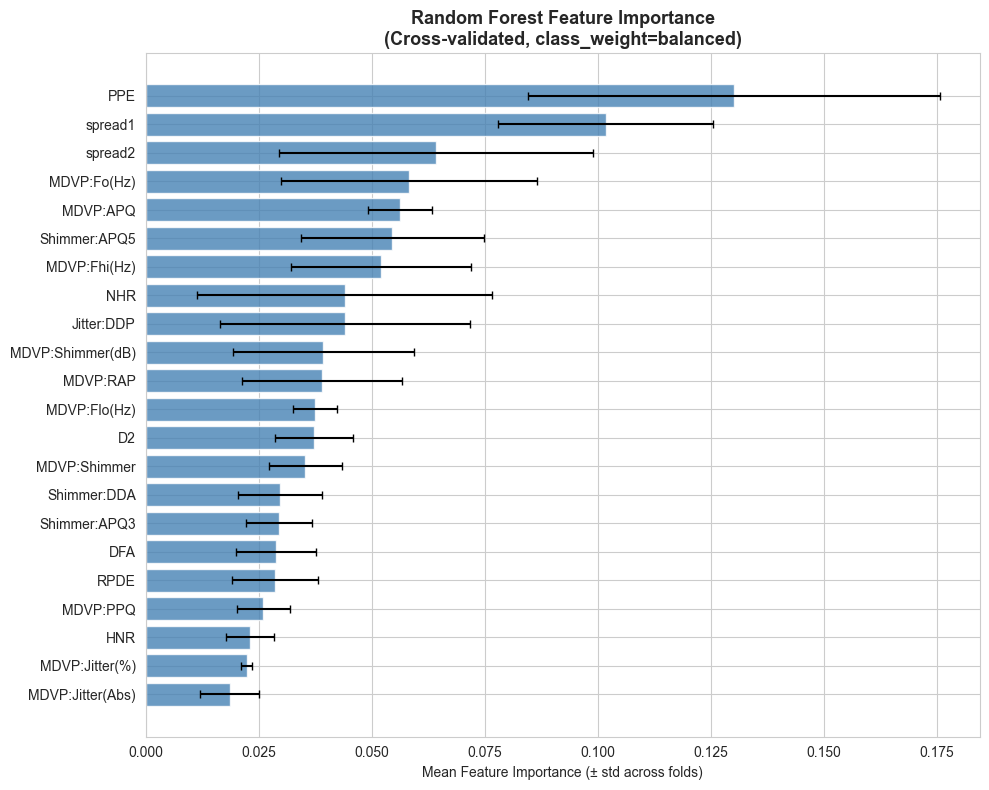

Top 10 features by RF importance:
                   PPE: 0.1301 ± 0.0456
               spread1: 0.1017 ± 0.0238
               spread2: 0.0642 ± 0.0348
           MDVP:Fo(Hz): 0.0583 ± 0.0284
              MDVP:APQ: 0.0562 ± 0.0070
          Shimmer:APQ5: 0.0545 ± 0.0202
          MDVP:Fhi(Hz): 0.0520 ± 0.0199
                   NHR: 0.0440 ± 0.0327
            Jitter:DDP: 0.0440 ± 0.0277
      MDVP:Shimmer(dB): 0.0393 ± 0.0200


In [13]:
# Compute RF importance across CV folds for stability
gkf = GroupKFold(n_splits=N_SPLITS)
scaler = StandardScaler()
all_importances = []

for train_idx, test_idx in gkf.split(X, y, groups):
    X_train_scaled = scaler.fit_transform(X.iloc[train_idx])
    y_train = y.iloc[train_idx]
    
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE)
    rf.fit(X_train_scaled, y_train)
    all_importances.append(rf.feature_importances_)

importance_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance_mean': np.mean(all_importances, axis=0),
    'importance_std': np.std(all_importances, axis=0)
}).sort_values('importance_mean', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(importance_df['feature'], importance_df['importance_mean'],
        xerr=importance_df['importance_std'], capsize=3,
        color='steelblue', alpha=0.8, edgecolor='white')
ax.set_xlabel('Mean Feature Importance (± std across folds)')
ax.set_title('Random Forest Feature Importance\n(Cross-validated, class_weight=balanced)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/rf_feature_importance.png', bbox_inches='tight')
plt.show()

print('Top 10 features by RF importance:')
for _, row in importance_df.tail(10).iloc[::-1].iterrows():
    print(f"  {row['feature']:>20s}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

## 6. Compare Feature Sets Across All Classifiers

In [14]:
# Define feature sets to compare
# Use the best PCA component count from Section 3 — update this based on your results
BEST_PCA_N = 10  # <-- adjust after reviewing Section 3 results

feature_sets = {
    'All (22)': FEATURE_COLS,
    'SVM-RFE': svm_rfe_features if len(svm_rfe_features) > 0 else FEATURE_COLS,
    'RF-RFE': rf_rfe_features if len(rf_rfe_features) > 0 else FEATURE_COLS,
    'RFE Union': union_features,
}

# Run all classifiers with each feature set (using class_weight='balanced')
feat_results = {}

for feat_name, feat_list in feature_sets.items():
    print(f'\n=== Feature Set: {feat_name} ({len(feat_list)} features) ===')
    X_subset = X[feat_list]
    feat_results[feat_name] = run_all_baselines(
        X_subset, y, groups, use_smote=False, class_weight='balanced', n_splits=N_SPLITS
    )

# Also run PCA version
print(f'\n=== Feature Set: PCA ({BEST_PCA_N} components) ===')
feat_results[f'PCA ({BEST_PCA_N})'] = {}
classifiers = get_classifiers(class_weight='balanced')
for name, clf in classifiers.items():
    print(f'  Running {name}...')
    pipe = build_pipeline(clf, use_pca=True, n_components=BEST_PCA_N)
    feat_results[f'PCA ({BEST_PCA_N})'][name] = run_grouped_cv(pipe, X, y, groups, n_splits=N_SPLITS)

print('\nDone!')


=== Feature Set: All (22) (22 features) ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

=== Feature Set: SVM-RFE (10 features) ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

=== Feature Set: RF-RFE (8 features) ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

=== Feature Set: RFE Union (14 features) ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

=== Feature Set: PCA (10 components) ===
  Running SVM_RBF...
  Running SVM_Linear...
  Running KNN...
  Running Random_Forest...
  Running Logistic_L1...
  Running Logistic_L2...

Done!


In [15]:
# Build comparison table: feature set × model, metric = balanced_accuracy
feat_rows = []
for feat_name, model_results in feat_results.items():
    for model_name, cv_result in model_results.items():
        row = {'feature_set': feat_name, 'model': model_name}
        row.update(cv_result['mean_metrics'])
        feat_rows.append(row)

feat_df = pd.DataFrame(feat_rows).round(4)

# Pivot tables for key metrics
for metric in ['balanced_accuracy', 'sensitivity', 'specificity', 'f1', 'mcc']:
    pivot = feat_df.pivot(index='model', columns='feature_set', values=metric)
    print(f'\n--- {metric.upper()} by Feature Set ---')
    print(pivot.to_string())


--- BALANCED_ACCURACY by Feature Set ---
feature_set    All (22)  PCA (10)  RF-RFE  RFE Union  SVM-RFE
model                                                        
KNN              0.6086    0.5921  0.7342     0.7225   0.6541
Logistic_L1      0.6817    0.6661  0.6705     0.6636   0.7497
Logistic_L2      0.6567    0.6785  0.6969     0.6436   0.7432
Random_Forest    0.6481    0.6372  0.6995     0.6595   0.6642
SVM_Linear       0.6304    0.6233  0.6686     0.6249   0.7026
SVM_RBF          0.6049    0.6081  0.6872     0.6663   0.7956

--- SENSITIVITY by Feature Set ---
feature_set    All (22)  PCA (10)  RF-RFE  RFE Union  SVM-RFE
model                                                        
KNN              0.8840    0.8842  0.9184     0.9117   0.8915
Logistic_L1      0.8135    0.7988  0.7743     0.7939   0.7995
Logistic_L2      0.8135    0.8070  0.7939     0.7872   0.7864
Random_Forest    0.9129    0.9244  0.9324     0.9191   0.8784
SVM_Linear       0.7775    0.7632  0.7372     0.7499  

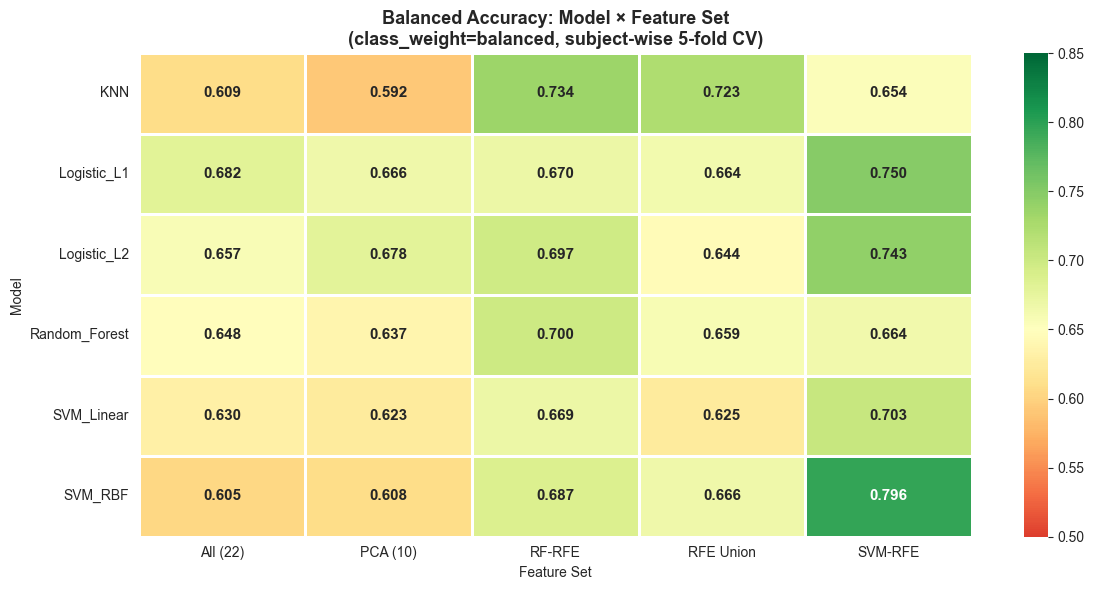

In [16]:
# Heatmap: balanced accuracy for model × feature set
pivot_ba = feat_df.pivot(index='model', columns='feature_set', values='balanced_accuracy')

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pivot_ba, annot=True, fmt='.3f', cmap='RdYlGn', center=0.65,
            linewidths=1, ax=ax, vmin=0.5, vmax=0.85,
            annot_kws={'size': 11, 'fontweight': 'bold'})
ax.set_title('Balanced Accuracy: Model × Feature Set\n(class_weight=balanced, subject-wise 5-fold CV)',
             fontsize=13, fontweight='bold')
ax.set_ylabel('Model')
ax.set_xlabel('Feature Set')
plt.tight_layout()
plt.savefig('../figures/feature_set_heatmap.png', bbox_inches='tight')
plt.show()

---
# Part C: Combined Analysis — Best Configuration per Model

In [17]:
# Find the best (imbalance strategy, feature set) for each model
all_experiments = []

# Combine imbalance results (all features) with feature results (class_weight=balanced)
for strat in strategies:
    for model_name, cv_result in imbalance_results[strat].items():
        row = {
            'model': model_name,
            'imbalance': strat,
            'features': 'All (22)',
        }
        row.update(cv_result['mean_metrics'])
        all_experiments.append(row)

# Add feature selection results (already using class_weight=balanced)
for feat_name, model_results in feat_results.items():
    if feat_name == 'All (22)':  # already covered above
        continue
    for model_name, cv_result in model_results.items():
        row = {
            'model': model_name,
            'imbalance': 'class_weight',
            'features': feat_name,
        }
        row.update(cv_result['mean_metrics'])
        all_experiments.append(row)

all_exp_df = pd.DataFrame(all_experiments).round(4)

# Best config per model by balanced accuracy
print('Best configuration per model (by balanced accuracy):\n')
best_configs = all_exp_df.loc[all_exp_df.groupby('model')['balanced_accuracy'].idxmax()]
best_configs = best_configs.sort_values('balanced_accuracy', ascending=False)
print(best_configs[['model', 'imbalance', 'features', 'balanced_accuracy',
                     'sensitivity', 'specificity', 'f1', 'mcc']].to_string(index=False))

Best configuration per model (by balanced accuracy):

        model    imbalance features  balanced_accuracy  sensitivity  specificity     f1    mcc
      SVM_RBF class_weight  SVM-RFE             0.7956       0.7579       0.8333 0.8252 0.5106
  Logistic_L1 class_weight  SVM-RFE             0.7497       0.7995       0.7000 0.8406 0.4562
  Logistic_L2 class_weight  SVM-RFE             0.7432       0.7864       0.7000 0.8293 0.4443
          KNN class_weight   RF-RFE             0.7342       0.9184       0.5500 0.8909 0.4559
   SVM_Linear class_weight  SVM-RFE             0.7026       0.7719       0.6333 0.8118 0.3668
Random_Forest class_weight   RF-RFE             0.6995       0.9324       0.4667 0.8850 0.4052


In [18]:
# Save all experiment results
all_exp_df.to_csv('../results/all_experiments.csv', index=False)
best_configs.to_csv('../results/best_configs_per_model.csv', index=False)

# Save feature rankings
svm_rfe_ranking.to_csv('../results/svm_rfe_ranking.csv', index=False)
rf_rfe_ranking.to_csv('../results/rf_rfe_ranking.csv', index=False)
importance_df.to_csv('../results/rf_feature_importance.csv', index=False)

print('All results saved to results/')

All results saved to results/


## 7. Key Takeaways

Fill in after running:

**Imbalance Strategies:**
1. Best overall strategy: ___ 
2. Impact on specificity: No balancing → ___, Class weighting → ___, SMOTE → ___
3. Class weighting vs SMOTE: ___ (which is better and why?)

**Feature Selection:**
1. PCA impact: Best component count = ___, effect on balanced accuracy = ___
2. Most stable RFE features (selected in all 5 folds): ___
3. Feature overlap between SVM-RFE and RF-RFE: ___
4. Top RF importance features: ___
5. Consistent across all methods: ___ (likely PPE, spread1, HNR, RPDE)

**Best Configurations:**
1. Best model + config: ___ with balanced accuracy of ___
2. Does feature selection help? ___

**Next step**: Notebook 04 — Hyperparameter Tuning with Nested CV